# Installations


In [1]:
# my login - timakaznet, hust regirster wanbd account and u'll take trial period which is enough
! wandb login 09c020c5c07d53e4cc16349e5e67d04db9673006

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\TimurRashitov/.netrc


In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Dataset Imports


In [3]:
import transformers
from torch.utils import data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# data processing
import re, string
import emoji
import nltk

# dataset
from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

# preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re, string

from tqdm import tqdm
from collections import defaultdict

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TimurRashitov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TimurRashitov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TimurRashitov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# list of pretrained models: https://huggingface.co/transformers/v3.3.1/pretrained_models.html
models = ["distilbert-base-uncased", "bert-base-uncased", "bert-base-cased"]
modelName = models[2] 

In [5]:
# We define utility functions for text processing.

def removePunctuation(text):
    """
    Remove punctuation symbols and convert text to lowercase
    """
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def removeStopWords(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([word for word in text.split() if word not in stopwords.words("english")])

def buildDictionary(texts):
    """
    Build the dictionary of words where key is the word and value is the index.
    """
    hashmap = {}
    for text in texts:
        for word in text.split():
            hashmap[word] = hashmap.get(word, 0) + 1
    return {w:i+1 for i, w in enumerate(list(hashmap.keys()))}

def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

def lemmatize(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_certain_numbers(text):
    return text.replace('20', ' ')

def remove_non_dictionary_words(text):
    return " ".join([word for word in text.split() if word in fast_text_dictionary])

In [6]:
data = pd.read_csv("C:/datasets/SMS/spam.csv")

In [10]:
data["target"] = data["target"].replace("ham", 0)
data["target"] = data["target"].replace("spam", 1)

In [11]:
data["target"].value_counts()

0    4825
1     747
Name: target, dtype: int64

In [18]:
data["text"] = data["text"].astype('str')

In [19]:
(data["text"].isna().sum() / data["text"].shape[0])

0.0

In [20]:
data["text"].loc[1]

'ok lar joking wif u oni'

In [21]:
# Text preprocessing. Remove punctuation symbols and stop words:
data["text"] = data["text"].apply(lambda x: removePunctuation(x))
data["text"] = data["text"].apply(lambda x: removeStopWords(x))
data["text"] = data["text"].apply(lambda x: lemmatize(x))

In [22]:
data["text"].loc[1]

'ok lar joking wif u oni'

In [23]:
data = data[["text", "target"]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   target  5572 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [25]:
data.drop_duplicates(subset='text',inplace=True)
data = data.reset_index(drop=True)
data.head()

,text,target
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor u c already say,0
4,nah dont think go usf life around though,0


In [26]:
data.isnull().sum()

text      0
target    0
dtype: int64

In [27]:
data["target"].value_counts()

0    4484
1     631
Name: target, dtype: int64

In [28]:
# word tokenizer
data['text_len_by_words'] = data['text'].apply(lambda t: len(t.split()))
min_len_word, max_len_word = data['text_len_by_words'].min(), data['text_len_by_words'].max()
print(min_len_word, max_len_word)

1 80


<AxesSubplot:xlabel='text_len_by_words', ylabel='Count'>

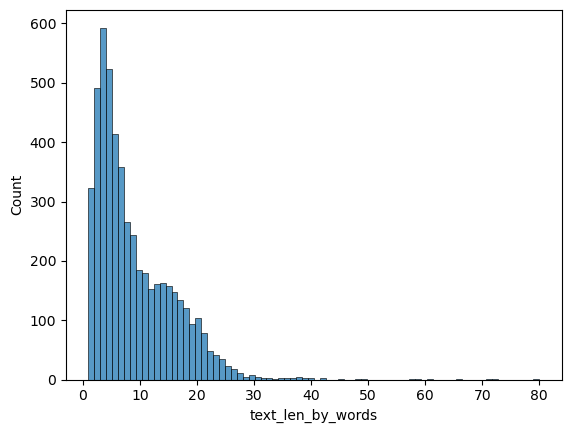

In [29]:
sns.histplot(data['text_len_by_words'])

# padding is based on the token lengths not the word lengths > MAX_LEN=64

[Text(0, 0, 'ham'), Text(1, 0, 'spam')]

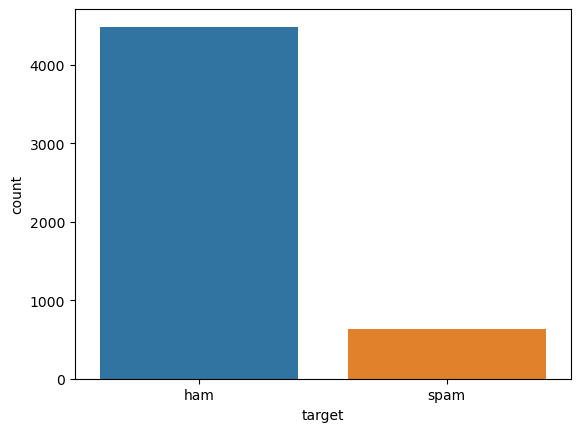

In [30]:
class_names = ["ham", "spam"]
ax = sns.countplot(x='target', data=data)
ax.set_xticklabels(class_names)

In [31]:
data

,text,target,text_len_by_words
0,go jurong point crazy available bugis n great ...,0,16
1,ok lar joking wif u oni,0,6
2,free entry 2 wkly comp win fa cup final tkts 2...,1,23
3,u dun say early hor u c already say,0,9
4,nah dont think go usf life around though,0,8
...,...,...,...
5110,2nd time tried 2 contact u u å£750 pound prize...,1,20
5111,ì b going esplanade fr home,0,6
5112,pity mood soany suggestion,0,4
5113,guy bitching acted like id interested buying s...,0,14


In [32]:
# Split data into training and testing
x_train, x_valid, y_train, y_valid = train_test_split(data["text"], data["target"], test_size=0.2, stratify=data["target"], random_state=42)

data = pd.concat((x_train, y_train), axis=1).reset_index(drop=True)
valid = pd.concat((x_valid, y_valid), axis=1).reset_index(drop=True)

In [36]:
def createDataset(df, textCol, labelCol, num_classes):
    dataset_dict = {
      'text' : df[textCol],
      'labels' : df[labelCol],
  }
    sent_tags = ClassLabel(num_classes=num_classes , names=['ham', 'spam'])

    return Dataset.from_dict(
      mapping = dataset_dict,
      features = Features({'text' : Value(dtype='string') , 'labels' :sent_tags})
  )

In [37]:
num_classes = 2
dataset_train = createDataset(data,"text","target", num_classes)
dataset_val = createDataset(valid,"text","target", num_classes)
dataset_test = createDataset(valid,"text","target", num_classes)

dataset_sentAnalysis = DatasetDict()
dataset_sentAnalysis["train"] = dataset_train
dataset_sentAnalysis["val"] = dataset_val
dataset_sentAnalysis["test"] = dataset_test

dataset_sentAnalysis

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4092
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 1023
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 1023
    })
})

# Data Preprocessing

In [38]:
def convert_to_lower(text):
    return text.lower()

def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)

    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    return wierd_pattern.sub(r'', text)

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def preprocessText(text):
  return remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(text))))))

def preprocessBatch(batch):
  new_list = []
  for i in batch["text"]:
    new_list.append(remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(i)))))))
  batch["text"] = new_list
  return batch

In [39]:
dataset_sentAnalysis_preprocessed = dataset_sentAnalysis.map(preprocessBatch, batched=True, batch_size=32)

  0%|          | 0/128 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [40]:
dataset_sentAnalysis["train"][10]

{'text': 'call time job today ok umma ask speed', 'labels': 0}

In [41]:
dataset_sentAnalysis_preprocessed["train"][10]

{'text': 'call time job today ok umma ask speed', 'labels': 0}

# Tokenizer


In [42]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(modelName)

In [43]:
max_len = 128
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=max_len)

In [44]:
sample_text = "What is  going on @resturant.:( It makes   Me Feel Upset.😞"
tokens = tokenizer.tokenize(sample_text)
print(len(tokens), tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids), token_ids)

token_dictionary = tokenizer(sample_text)
print(token_dictionary)
print(len(token_dictionary.input_ids)) # automatically added cls, sep

tokens = tokenizer.convert_ids_to_tokens(token_dictionary['input_ids'])
print(tokens)

token_encode = tokenizer.encode(sample_text) #convert to tokens ids but with cls+sep
print(token_encode)

19 ['What', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'It', 'makes', 'Me', 'Feel', 'Up', '##set', '.', '[UNK]']
19 [1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100]
{'input_ids': [101, 1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
21
['[CLS]', 'What', 'is', 'going', 'on', '@', 'rest', '##ura', '##nt', '.', ':', '(', 'It', 'makes', 'Me', 'Feel', 'Up', '##set', '.', '[UNK]', '[SEP]']
[101, 1327, 1110, 1280, 1113, 137, 1832, 4084, 2227, 119, 131, 113, 1135, 2228, 2508, 14425, 3725, 9388, 119, 100, 102]


In [45]:
# we use special tokens to separate the sentences. How bert works
print(tokenizer)
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

PreTrainedTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [46]:
# the inputs same as distilbert_tokenizer()
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=max_len,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors="pt"
)
encoding

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\TimurRashitov\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': tensor([[  101,  1327,  1110,  1280,  1113,   137,  1832,  4084,  2227,   119,
           131,   113,  1135,  2228,  2508, 14425,  3725,  9388,   119,   100,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [47]:
dataset_sentAnalysis_encoded = dataset_sentAnalysis_preprocessed.map(tokenize, batched=True, batch_size=32)

  0%|          | 0/128 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [48]:
dataset_sentAnalysis_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4092
    })
    val: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1023
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1023
    })
})

# Add Classification head manually for Model


In [49]:
from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class BertForClassification(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # Load model body > return all og the HS
        self.bert = BertModel(config)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.bert(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)

        # Apply classifier to encoder representation > [cls]
        sequence_output = self.dropout(outputs[1])
        logits = self.classifier(sequence_output)

        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [51]:
from transformers import AutoConfig

id2label = {
    0: 'ham',
    1: 'spam'
}

label2id = { v:k for (k,v) in id2label.items()}

bert_config = AutoConfig.from_pretrained(modelName, 
                                         num_labels=2,
                                         id2label=id2label, label2id=label2id)

In [52]:
bert_model = (BertForClassification
              .from_pretrained(modelName, config=bert_config)
              .to(device))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForClassification were not initialized from the model checkpoint at bert-base-cased and are newly ini

# Training Arguments

In [53]:
from transformers import Trainer, TrainingArguments
import wandb
wandb.login()

wandb.init(project="bert-for-english-classification")

num_epochs = 6
batch_size = 32
logging_steps = len(dataset_sentAnalysis_encoded["train"]) // batch_size
model_name = f"{modelName}-finetuned-sentimentAnalysis-bert"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  save_steps=1e6,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error",
                                  report_to="wandb",
                                  run_name="bert-sent-analysis",
                                  save_total_limit = 5,
                                  load_best_model_at_end=True
                                 )

wandb: Currently logged in as: timurchik (timka). Use `wandb login --relogin` to force relogin


In [54]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [55]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(bert_model.parameters(), lr=2e-5)

In [56]:
num_training_steps = num_epochs * logging_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

trainer_preprocessed_lr = Trainer(model=bert_model, args=training_args,
                                  compute_metrics=compute_metrics,
                                  train_dataset=dataset_sentAnalysis_encoded["train"],
                                  eval_dataset=dataset_sentAnalysis_encoded["val"],
                                  tokenizer=tokenizer,
                                  optimizers=(optimizer,lr_scheduler))

trainer_preprocessed_lr.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.130100,0.084829,0.978495,0.978911
2,0.040200,0.066496,0.982405,0.982464
3,0.018200,0.071605,0.983382,0.983354
4,0.013200,0.087994,0.982405,0.982522
5,0.005800,0.079342,0.985337,0.985312
6,0.004900,0.083041,0.985337,0.985312


TrainOutput(global_step=768, training_loss=0.03517368835794817, metrics={'train_runtime': 509.2879, 'train_samples_per_second': 48.208, 'train_steps_per_second': 1.508, 'total_flos': 1193475858223200.0, 'train_loss': 0.03517368835794817, 'epoch': 6.0})

# Evaluation



In [50]:
dataset_sentAnalysis_encoded["test"]

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2861
})

In [60]:
model = bert_model
model.eval()
preds_output = trainer_preprocessed_lr.predict(dataset_sentAnalysis_encoded["test"])
pd.DataFrame(list(preds_output.metrics.items())).T

,0,1,2,3,4,5
0,test_loss,test_accuracy,test_f1,test_runtime,test_samples_per_second,test_steps_per_second
1,0.066496,0.982405,0.982464,3.8017,269.092,8.417


In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [62]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [63]:
labels

['ham', 'spam']

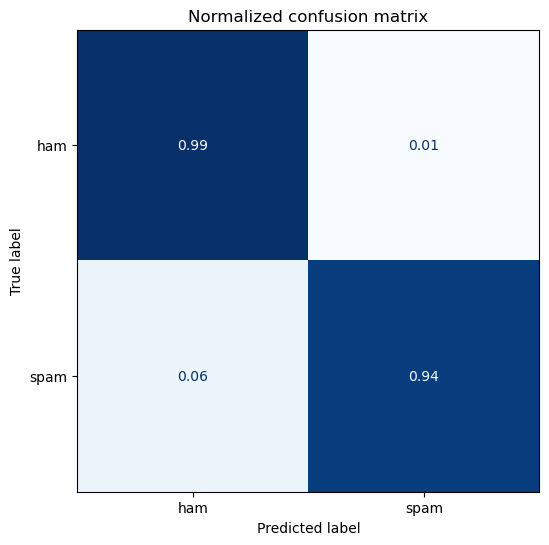

In [64]:
y_test = np.array(dataset_sentAnalysis_encoded["test"]["labels"])
labels = dataset_sentAnalysis_encoded["train"].features["labels"].names
plot_confusion_matrix(y_preds, y_test, labels)

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['ham', 'spam']
print(classification_report(y_test, y_preds, target_names=class_names))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       897
        spam       0.92      0.94      0.93       126

    accuracy                           0.98      1023
   macro avg       0.96      0.96      0.96      1023
weighted avg       0.98      0.98      0.98      1023



# Predict one input

In [66]:
import numpy as np
import torch.nn.functional as F

def predict_text(model,text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    out = F.softmax(outputs.logits,dim=1)
    y_out = np.argmax(out.cpu(),axis=1)
    return out, y_out

In [69]:
sample_text = "increase your benefit by buying a new stuff on www.sell.com"
out, y_out = predict_text(model,sample_text)
out, id2label[y_out.item()]

(tensor([[0.1787, 0.8213]], device='cuda:0'), 'spam')

In [70]:
pd.set_option('display.max_colwidth', -1)
pd.DataFrame({
    "Text": sample_text,
    "Sentiment": class_names[y_out.item()]
},index=[0]).T

C:\Users\TimurRashitov\AppData\Local\Temp\ipykernel_1176\1348095419.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,0
Text,increase your benefit by buying a new stuff on www.sell.com
Sentiment,spam
